<a href="https://colab.research.google.com/github/Bushra-Alandijani/Bushra_Resume/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import math
import glob
import numpy as np
from google.colab.patches import cv2_imshow
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
def preprocessing(img_path):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (256, 256))
    img = np.array(img)
    img = np.expand_dims(img, axis=2)
    img = img/256
    return img


In [4]:
def prediction_fun(X_img, model):

    pixel_to_cm = 0.02  # Example conversion: 1 pixel = 0.02 cm
    out = X_img.copy()

    out = (out * 255).astype(np.uint8)
    out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)

    x_img = np.expand_dims(X_img,0)
    prediction=(model.predict(x_img)[0,:,:,:]>.1).astype(np.uint8)
    image = (prediction * 255).astype(np.uint8)

    # Apply Gaussian blur to the image to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Threshold the image
    _, thresholded = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    # Define a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)

    # Dilation & Erosion
    dilated = cv2.dilate(thresholded, kernel, iterations=3)
    eroded = cv2.erode(dilated, kernel, iterations=2)
    img = np.expand_dims(eroded, 2)

    _, thresholded = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)


    measurements = {"HC": 0, "BPD": 0, "OFD": 0}

    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        if len(contour) >= 5 :
            ellipse = cv2.fitEllipse(contour)

            # Extract the ellipse parameters
            (center, axes, angle) = ellipse
            major_axis = max(axes)  # Major axis length (full length in pixels)
            minor_axis = min(axes)  # Minor axis length (full length in pixels)

                    # Semi-major and semi-minor axes (half-lengths in pixels)
            a = major_axis / 2.0
            b = minor_axis / 2.0

            # Calculate circumference using Ramanujan's approximation (in pixels)
            circumference_pixels = math.pi * (3 * (a + b) - math.sqrt((3 * a + b) * (a + 3 * b)))

            # Convert measurements to centimeters
            measurements["HC"] = round(circumference_pixels * pixel_to_cm, 2)
            measurements["BPD"] = round(minor_axis * pixel_to_cm, 2)
            measurements["OFD"] = round(major_axis * pixel_to_cm, 2)

            image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

            cv2.ellipse(image_bgr, ellipse, (0,255,0), 2)
            cv2.ellipse(out, ellipse, (0, 255, 0), 2)

            center = tuple(map(int, center))
            major_axis_vector = (int(a * math.cos(math.radians(angle + 90))),
                               int(a * math.sin(math.radians(angle + 90))))
            minor_axis_vector = (int(b * math.cos(math.radians(angle))),
                               int(b * math.sin(math.radians(angle))))

            cv2.line(out,
                    (center[0] - major_axis_vector[0], center[1] - major_axis_vector[1]),
                    (center[0] + major_axis_vector[0], center[1] + major_axis_vector[1]),
                    (0, 255, 0), 2)

            # Draw BPD (minor axis)
            cv2.line(out,
                    (center[0] - minor_axis_vector[0], center[1] - minor_axis_vector[1]),
                    (center[0] + minor_axis_vector[0], center[1] + minor_axis_vector[1]),
                    (0, 255, 0), 2)

            print(f"HC: {measurements['HC']} cm",
            f"BPD: {measurements['BPD']} cm",
            f"OFD: {measurements['OFD']} cm")
    plt.imshow(out)
    plt.show()

In [7]:
model_3 = load_model('/content/drive/MyDrive/Colab Notebooks/AC/head circumference_biparietal diameter/u_net_model_v3.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
HC: 8.47 cm BPD: 2.07 cm OFD: 3.26 cm


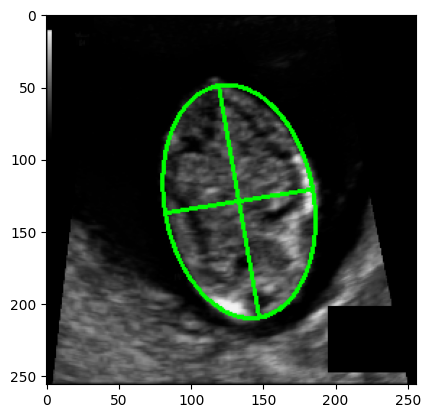

In [11]:
img_path = "/content/drive/MyDrive/Colab Notebooks/AC/head circumference_biparietal diameter/train_set/Images/013_HC.png"
pre_img = preprocessing(img_path)
prediction_fun(pre_img, model_3)